<a href="https://colab.research.google.com/github/amirkasaei/Intelligent-Analysis-of-Biomedical-Images/blob/main/HW/HW5/Prac/BreastMNIST_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary Classification using Swin Transformer

**Introduction**:

In this educational notebook, we will explore binary classification on the BreastMNIST dataset, consisting of 780 breast ultrasound images. This task involves using the Swin Transformer, a cutting-edge neural network model, to distinguish between benign (including normal) and malignant cases.

We'll tackle the common challenge of class imbalance in medical datasets and learn to improve model performance using class weights. Additionally, we'll delve into evaluating our model with ROC curves and AUC, essential tools for assessing performance in medical image classification.


## Packages & Modules

In [ ]:
!pip install -q torchmetrics
!pip install -q timm
!pip install -q medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
from IPython.display import clear_output

import torch
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

from torchmetrics import Accuracy, F1Score, ConfusionMatrix

from torchmetrics import Accuracy
from timm import create_model
import medmnist
import sklearn
from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns

device = "cuda" if torch.cuda.is_available() else "cpu"
clear_output()

## Data

The BreastMNIST dataset is simplified into a binary classification problem, merging normal and benign images into a single class, contrasting against malignant images. The dataset, originally 1×500×500 in size, is resized to 1×28×28 and split into training, validation, and test sets. We address the class imbalance by applying class weights in our loss function, enhancing the focus on underrepresented classes.

In [ ]:
info = medmnist.INFO['breastmnist']
n_channels = info['n_channels']

DataClass = getattr(medmnist, info['python_class'])

In [ ]:
print(info['n_samples'])
print(info['label'])

{'train': 546, 'val': 78, 'test': 156}
{'0': 'malignant', '1': 'normal, benign'}


In [ ]:
# preprocessing
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.AugMix(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])



BATCH_SIZE = 16

# load the data
train_dataset = DataClass(split='train', transform=train_transform, download=True)
val_dataset = DataClass(split='val', transform=train_transform, download=True)
test_dataset = DataClass(split='test', transform=test_transform, download=True)

# Create instances of your dataset and data loader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz


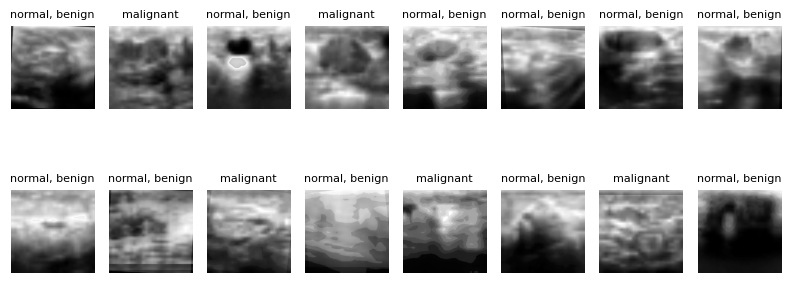

In [ ]:
images, labels = next(iter(train_loader))
images = images[:16]
labels = labels[:16]

fig, axes = plt.subplots(2, 8, figsize=(8, 4))

for i, ax in enumerate(axes.flatten()):
    # Convert the tensor image to numpy array format
    image = images[i].numpy().transpose(1, 2, 0)
    # Normalize the image to the range [0, 1]
    image = (image + 1) / 2
    ax.imshow(image, cmap='gray')
    ax.axis("off")
    ax.set_title(f"{info['label'][str(labels[i].item())]}", fontsize=8)

plt.tight_layout()
plt.show()

## Train

In [ ]:
model = create_model(model_name="swin_tiny_patch4_window7_224",
                        pretrained=True,
                        num_classes=1,
                        in_chans=n_channels)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion =  nn.BCEWithLogitsLoss()
sigmoid = nn.Sigmoid()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
    model.train()
    total_loss = 0.0
    total_acc = 0.0

    y_pred, y_true = [], []

    # Iterate over data.
    for inputs, labels in train_loader:
      inputs = inputs.to(device)
      labels = labels.type(torch.FloatTensor).to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward
      with torch.set_grad_enabled(True):
        outputs = model(inputs)
        preds = (sigmoid(outputs) > 0.5).float()
        loss = loss_fn(outputs, labels)

        y_pred.extend(preds.cpu())
        y_true.extend(labels.cpu())


        loss.backward()
        optimizer.step()

      # statistics
      total_loss += loss.item()
      total_acc += accuracy_score(labels.cpu(), preds.cpu())

    y_pred = torch.tensor(y_pred)
    y_true = torch.tensor(y_true)

    avg_loss = total_loss / len(train_loader)
    avg_acc = total_acc / len(train_loader)
    avg_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=1)
    cm = confusion_matrix(y_pred, y_true)


    return model, avg_loss, avg_acc, avg_f1, cm


In [ ]:
def validate_one_epoch(model, val_loader, criterion):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0

    y_pred, y_true = [], []

    for inputs, labels in val_loader:
      inputs = inputs.to(device)
      labels = labels.type(torch.FloatTensor).to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward
      with torch.set_grad_enabled(False):
        outputs = model(inputs)
        preds = (sigmoid(outputs) > 0.5).float()
        loss = criterion(outputs, labels)

        y_pred.extend(preds.cpu())
        y_true.extend(labels.cpu())


      # statistics
      total_loss += loss.item()
      total_acc += accuracy_score(labels.cpu(), preds.cpu())

    y_pred = torch.tensor(y_pred)
    y_true = torch.tensor(y_true)

    avg_loss = total_loss / len(val_loader)
    avg_acc = total_acc / len(val_loader)
    avg_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=1)
    cm = confusion_matrix(y_pred, y_true)

    return avg_loss, avg_acc, avg_f1, cm

In [ ]:
# Training Loop
n_epochs = 100
loss_train_hist = []
loss_valid_hist = []
acc_train_hist = []
acc_valid_hist = []
f1_train_hist = []
f1_valid_hist = []
cm_train_hist = []
cm_valid_hist = []

for epoch in range(n_epochs):
    torch.cuda.empty_cache()

    model, loss_train, acc_train, f1_train, cm_train = train_one_epoch(model, train_loader, criterion, optimizer, epoch)
    loss_valid, acc_valid, f1_valid, cm_valid = validate_one_epoch(model, val_loader, criterion)

    # Append metrics to history
    loss_train_hist.append(loss_train)
    loss_valid_hist.append(loss_valid)
    acc_train_hist.append(acc_train)
    acc_valid_hist.append(acc_valid)
    f1_train_hist.append(f1_train)
    f1_valid_hist.append(f1_valid)
    cm_train_hist.append(cm_train)
    cm_valid_hist.append(cm_valid)

    print(f"Epoch: {epoch+1}, Train Loss: {loss_train:.2f}, Train Acc: {acc_train:.2f}, Train F1: {f1_train:.2f}, Valid Loss: {loss_valid:.2f}, Valid Acc: {acc_valid:.2f}, Valid F1: {f1_valid:.2f}")


Epoch: 1, Train Loss: 0.57, Train Acc: 0.72, Train F1: 0.62, Valid Loss: 0.51, Valid Acc: 0.73, Valid F1: 0.62
Epoch: 2, Train Loss: 0.49, Train Acc: 0.77, Train F1: 0.70, Valid Loss: 0.42, Valid Acc: 0.86, Valid F1: 0.85
Epoch: 3, Train Loss: 0.45, Train Acc: 0.82, Train F1: 0.80, Valid Loss: 0.36, Valid Acc: 0.86, Valid F1: 0.85
Epoch: 4, Train Loss: 0.46, Train Acc: 0.80, Train F1: 0.78, Valid Loss: 0.41, Valid Acc: 0.88, Valid F1: 0.88
Epoch: 5, Train Loss: 0.41, Train Acc: 0.85, Train F1: 0.84, Valid Loss: 0.34, Valid Acc: 0.87, Valid F1: 0.87
Epoch: 6, Train Loss: 0.39, Train Acc: 0.84, Train F1: 0.84, Valid Loss: 0.28, Valid Acc: 0.93, Valid F1: 0.92
Epoch: 7, Train Loss: 0.39, Train Acc: 0.84, Train F1: 0.83, Valid Loss: 0.27, Valid Acc: 0.90, Valid F1: 0.89
Epoch: 8, Train Loss: 0.34, Train Acc: 0.88, Train F1: 0.87, Valid Loss: 0.31, Valid Acc: 0.90, Valid F1: 0.89
Epoch: 9, Train Loss: 0.36, Train Acc: 0.85, Train F1: 0.84, Valid Loss: 0.27, Valid Acc: 0.91, Valid F1: 0.90
E

In [ ]:
def plot_performance(loss_train_hist, loss_valid_hist, acc_train_hist, acc_valid_hist):
    plt.figure(figsize=(6, 3))

    plt.subplot(1, 2, 1)
    plt.plot(loss_train_hist, label='Train Loss')
    plt.plot(loss_valid_hist, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(acc_train_hist, label='Train Accuracy')
    plt.plot(acc_valid_hist, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

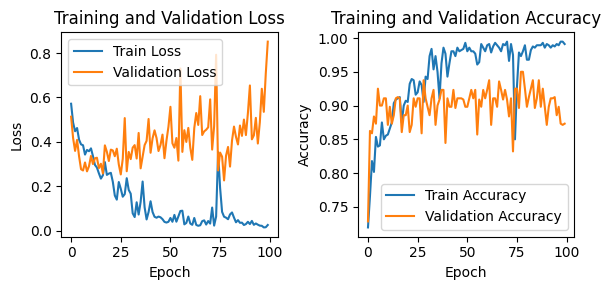

In [ ]:
plot_performance(loss_train_hist, loss_valid_hist, acc_train_hist, acc_valid_hist)

**Discussing the Limitations of Accuracy**

While accuracy is a commonly used metric, it can be misleading, especially in cases of class imbalance. In such scenarios, a model might predict the majority class for all instances, resulting in high accuracy but poor model performance in practical terms.

**Why F1-Score?**
The F1-score is a more robust metric in these cases as it balances precision and recall, providing a better measure of the classifier's performance, especially when the classes are imbalanced.

**Importance of Confusion Matrix**
The confusion matrix provides an in-depth view of the classifier's performance. It shows not just the overall accuracy but how the model performs on each individual class, revealing any biases or weaknesses in the model's predictions.


In [ ]:
def plot_f1_and_confusion_matrix(f1_train, f1_valid, cm_train, cm_valid):
    # Plotting F1-Score
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.bar(['Train F1', 'Valid F1'], [f1_train, f1_valid], color=['blue', 'green'])
    plt.title("F1-Score for Training and Validation")

    # Plotting Confusion Matrix
    plt.subplot(1, 2, 2)
    sns.heatmap(cm_valid, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix for Validation")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    plt.tight_layout()
    plt.show()

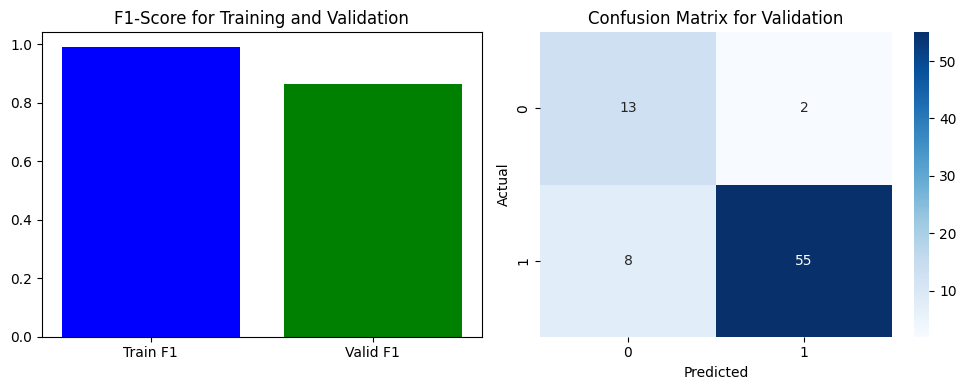

In [ ]:
plot_f1_and_confusion_matrix(f1_train_hist[-1], f1_valid_hist[-1], cm_train_hist[-1], cm_valid_hist[-1])

**Importance of ROC and AUC in Evaluation:**

In medical imaging tasks like ours, accuracy isn't always the best performance metric due to potential class imbalances. Instead, we use ROC (Receiver Operating Characteristic) curves and AUC (Area Under the Curve) to provide a more nuanced view of our model's ability to distinguish between classes, ensuring a more reliable assessment of its diagnostic accuracy.

In [ ]:
def evaluate_and_plot_roc(model, data_loader, device):
    """
    Evaluates the model on the given data loader, calculates the ROC curve and AUC,
    and plots the ROC curve.

    Parameters:
    model (torch.nn.Module): The trained model to evaluate.
    data_loader (torch.utils.data.DataLoader): DataLoader for evaluation data.
    device (torch.device): The device on which the model is.

    Returns:
    None
    """
    model.eval()

    y_prob, y_pred, y_true = [], [], []

    for inputs, labels in val_loader:
      inputs = inputs.to(device)
      labels = labels.type(torch.FloatTensor).to(device)

      # forward
      with torch.set_grad_enabled(False):
        outputs = model(inputs)
        probs = sigmoid(outputs)
        preds = (probs > 0.5).float()

        y_prob.extend(probs.cpu())
        # y_pred.extend(preds.cpu())
        y_true.extend(labels.cpu())

    y_prob = torch.tensor(y_prob)
    # y_pred = torch.tensor(y_pred)
    y_true = torch.tensor(y_true)
    # cm = sklearn.metrics.confusion_matrix(y_pred, y_true)

    # no skill probability
    ns_probs = torch.zeros(y_prob.shape[0])
    ns_fpr, ns_tpr, _ = roc_curve(y_true, ns_probs)

    fpr, tpr, _ = roc_curve(y_true, y_prob)

    # plot the roc curve
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='Swin Transformer')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()




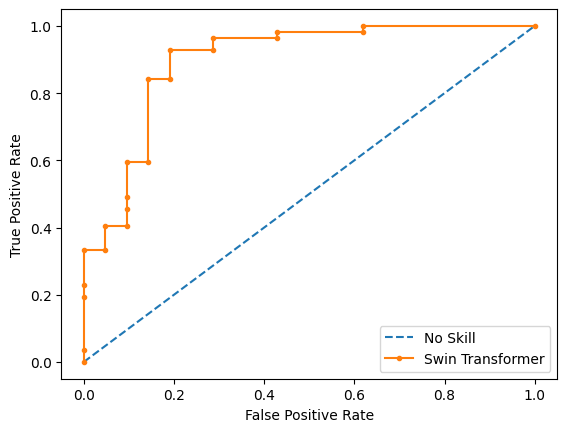

In [ ]:
evaluate_and_plot_roc(model, test_loader, device)

# Addressing Class Imbalance

**Explanation**

Class imbalance is a common challenge in medical data analysis. It happens when the number of examples in one class (usually the 'normal' category) is much larger than in another class (often representing a 'disease' condition). This imbalance can lead to models that are unfairly skewed towards the majority class, performing poorly in identifying the crucial, less represented class.


**Why Address Class Imbalance?**

In medical scenarios, the accuracy of detecting rare conditions (the minority class) is as important, if not more so, than identifying common ones. A model biased towards the majority class might overlook these critical minority cases, leading to potential misdiagnoses.


To counter this, one approach is to use a weighted loss function during training


In [ ]:
total_counts = len(train_dataset)
train_labels = np.array([train_dataset[i][1] for i in range(total_counts)]).squeeze(axis=1)

class_count = {}
class_count['malignant'] = np.sum(train_labels==0)
class_count['normal'] = total_counts - class_count['malignant']

majority_class = max(class_count, key=class_count.get)
minority_class = min(class_count, key=class_count.get)

print('ratio of samples in the majority class to the minority class:', class_count[majority_class]/class_count[minority_class])

class_weights = torch.tensor(compute_class_weight(class_weight = "balanced", classes=[0, 1], y=train_labels))
print(class_weights)

pos_weight = torch.tensor([class_count[minority_class] / class_count[majority_class]], device=device)
print(pos_weight)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# criterion = nn.BCEWithLogitsLoss(weight=class_weights)

ratio of samples in the majority class to the minority class: 2.7142857142857144
tensor([1.8571, 0.6842], dtype=torch.float64)
tensor([0.3684], device='cuda:0', dtype=torch.float64)


In [ ]:
model = create_model(model_name="swin_tiny_patch4_window7_224",
                        pretrained=True,
                        num_classes=1,
                        in_chans=n_channels)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Training Loop
n_epochs = 100
loss_train_hist = []
loss_valid_hist = []
acc_train_hist = []
acc_valid_hist = []
f1_train_hist = []
f1_valid_hist = []
cm_train_hist = []
cm_valid_hist = []

for epoch in range(n_epochs):
    torch.cuda.empty_cache()

    model, loss_train, acc_train, f1_train, cm_train = train_one_epoch(model, train_loader, criterion, optimizer, epoch)
    loss_valid, acc_valid, f1_valid, cm_valid = validate_one_epoch(model, val_loader, criterion)

    loss_train_hist.append(loss_train)
    loss_valid_hist.append(loss_valid)
    acc_train_hist.append(acc_train)
    acc_valid_hist.append(acc_valid)
    f1_train_hist.append(f1_train)
    f1_valid_hist.append(f1_valid)
    cm_train_hist.append(cm_train)
    cm_valid_hist.append(cm_valid)

    print(f"Epoch: {epoch+1}, Train Loss: {loss_train:.2f}, Train Acc: {acc_train:.2f}, Train F1: {f1_train:.2f}, Valid Loss: {loss_valid:.2f}, Valid Acc: {acc_valid:.2f}, Valid F1: {f1_valid:.2f}")

Epoch: 1, Train Loss: 0.36, Train Acc: 0.57, Train F1: 0.58, Valid Loss: 0.36, Valid Acc: 0.75, Valid F1: 0.67
Epoch: 2, Train Loss: 0.33, Train Acc: 0.69, Train F1: 0.69, Valid Loss: 0.28, Valid Acc: 0.72, Valid F1: 0.73
Epoch: 3, Train Loss: 0.30, Train Acc: 0.72, Train F1: 0.75, Valid Loss: 0.33, Valid Acc: 0.78, Valid F1: 0.73
Epoch: 4, Train Loss: 0.35, Train Acc: 0.61, Train F1: 0.62, Valid Loss: 0.25, Valid Acc: 0.88, Valid F1: 0.87
Epoch: 5, Train Loss: 0.29, Train Acc: 0.75, Train F1: 0.76, Valid Loss: 0.22, Valid Acc: 0.83, Valid F1: 0.84
Epoch: 6, Train Loss: 0.26, Train Acc: 0.79, Train F1: 0.79, Valid Loss: 0.26, Valid Acc: 0.87, Valid F1: 0.86
Epoch: 7, Train Loss: 0.26, Train Acc: 0.81, Train F1: 0.81, Valid Loss: 0.21, Valid Acc: 0.83, Valid F1: 0.84
Epoch: 8, Train Loss: 0.24, Train Acc: 0.82, Train F1: 0.82, Valid Loss: 0.21, Valid Acc: 0.90, Valid F1: 0.89
Epoch: 9, Train Loss: 0.22, Train Acc: 0.84, Train F1: 0.83, Valid Loss: 0.22, Valid Acc: 0.89, Valid F1: 0.88
E

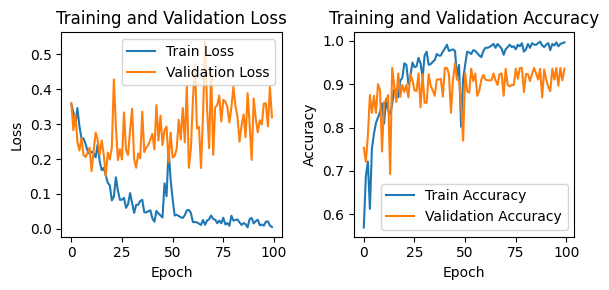

In [ ]:
plot_performance(loss_train_hist, loss_valid_hist, acc_train_hist, acc_valid_hist)

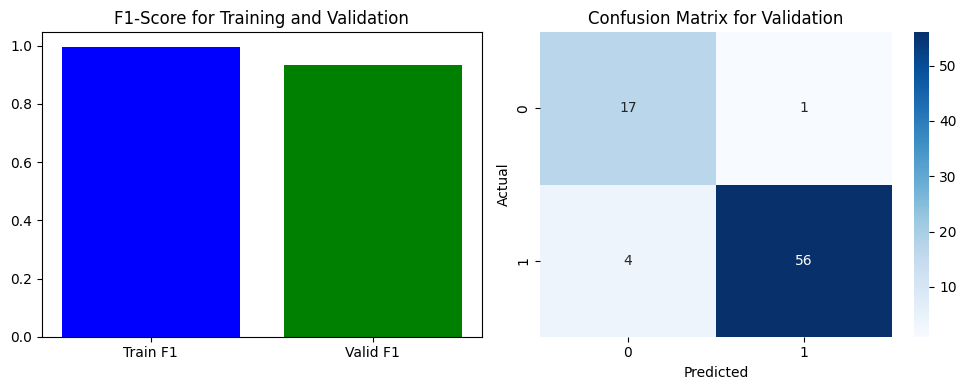

In [ ]:
plot_f1_and_confusion_matrix(f1_train_hist[-1], f1_valid_hist[-1], cm_train_hist[-1], cm_valid_hist[-1])

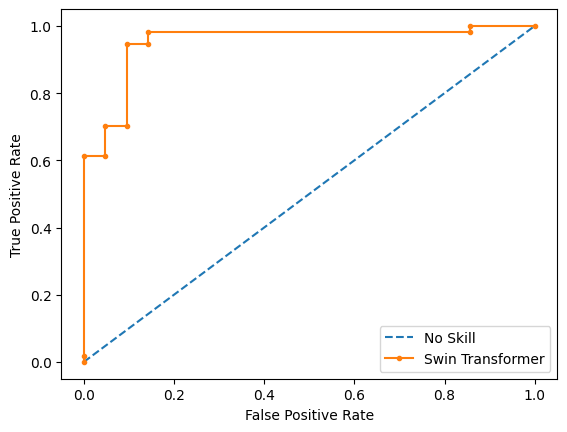

In [ ]:
evaluate_and_plot_roc(model, test_loader, device)

<br><br><br>

# Refrences
- [analyticsvidhya](https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/)
- [towardsdatascience](https://towardsdatascience.com/how-to-tackle-class-imbalance-without-resampling-47bbeb2180aa)